In [4]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

seed = 43
tf.random.set_seed(seed)
np.random.seed(seed)

In [10]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
    tf.keras.utils.get_file(
        'mini_speech_commands.zip',
        origin = "http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
        extract=True,
        cache_dir = ".",
        cache_subdir='data')

182082353/182082353 [==============================] - 216s 1us/step


In [11]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [12]:
print(data_dir)

data\mini_speech_commands


In [21]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
directory=data_dir,
batch_size=64,
validation_split=0.2,
seed=0,
output_sequence_length=16000,
subset='both')

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.


In [22]:
label_names = np.array(train_ds.class_names)
print("label names:", label_names)

label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [23]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

### making a squeeze function to drop down the extra axis in the audio file

In [24]:
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

### now spliting the validation set into test and validation set; by ussing a technique called sharding

In [25]:
test_ds = val_ds.shard(num_shards=2, index = 0)
val_ds = val_ds.shard(num_shards=2, index = 1)

In [27]:
for example_audio, example_label in train_ds.take(1):
    print(example_audio.shape)
    print(example_label.shape)

(64, 16000)
(64,)


### ploting the waveform

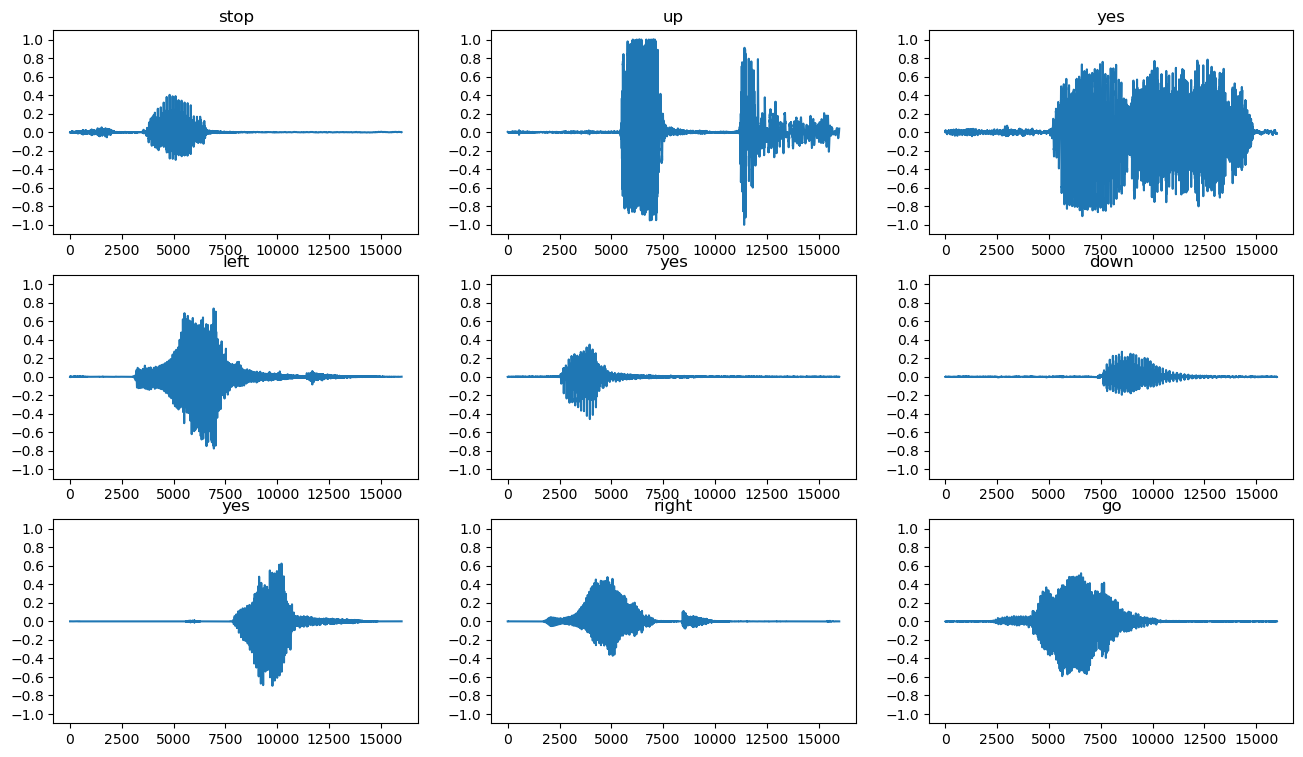

In [31]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    if i>= n:
        break
    r = i//cols
    c = i%cols
    ax = axes[r][c]
    ax.plot(example_audio[i].numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label_names[example_label[i]]
    ax.set_title(label)
    ax.set_ylim([-1.1, 1.1])
    
    
plt.show()

## Converting waveform audio to spectrogram audio

#### The data is stored in the waveform and is represented in time domain. But this can't be evaluated, we have to consider frequency changes too and not only amplitude changes. Therefore we do something called Short Time Fourier Transform(tf.signal.stft) to convert waveforms to spectrograms, which show frequency changes over time and can be represented as 2D images. WHich is then trained.

if the only fourier transform is done. Then thier is no ime domain left to explore and only frequency changes are detected over whole time. Therefore the fourier Transform is done over the small time changes; retaining the time component to some extent. Now, we can use convolutional nueral networks on this 2D tensor for analysis.

The leangth and height of the audio 2D tensor have to be same for CNNs to work, if they are not same then it can be made same by padding it with zero.

frame_length and frame_step define the time variability of the waveform, which will be converted while doing the fourier transform

In [32]:
def get_spectrogram(waveform):
    # Convert the waveform to a spectrogram via a STFT
    spectrogram = tf.signal.stft(waveform, frame_length = 255, frame_step = 128)
    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)
    # Add a 'channels' dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers(which expect the shape)
    # shape ('batch_size', 'height,'width','channels').
    
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

In [33]:
for i in range(3):
    label = label_names[example_label[i]]
    waveform = example_audio[i]
    spectrogram = get_spectrogram(waveform)
    
    print('Label', label)
    print('Waveform shape:', waveform.shape)
    print('Spectrogram shape:', spectrogram.shape)
    print('Audio playback')
    display.display(display.Audio(waveform, rate=16000))

Label stop
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label up
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label yes
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


### displaying the spectrogram

In [40]:
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis= -1)
        
    # convert the frequencies to log scale and transpose, so that the time is 
    # represented on the x_axis(columns).
    # Add an epsilon to avoid taking log of zero
    
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num= width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

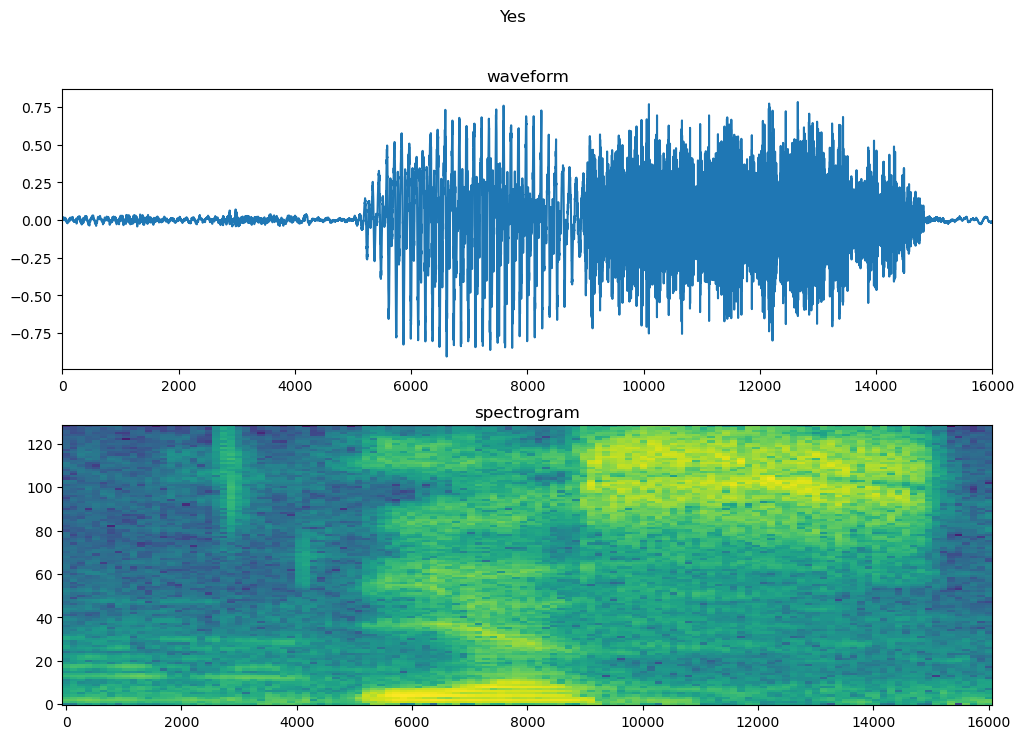

In [41]:
# plotting both one below another

fig, axes = plt.subplots(2, figsize=(12,8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('spectrogram')
plt.suptitle(label.title())
plt.show()

In [43]:
# making the spectrogram datasets from the given audio datasets

def make_spec_ds(ds):
    return ds.map(
    map_func = lambda audio, label: (get_spectrogram(audio), label),
    num_parallel_calls=tf.data.AUTOTUNE)

In [44]:
train_spectrogram_ds = make_spec_ds(train_ds)
test_spectrogram_ds = make_spec_ds(test_ds)
val_spectrogram_ds = make_spec_ds(val_ds)

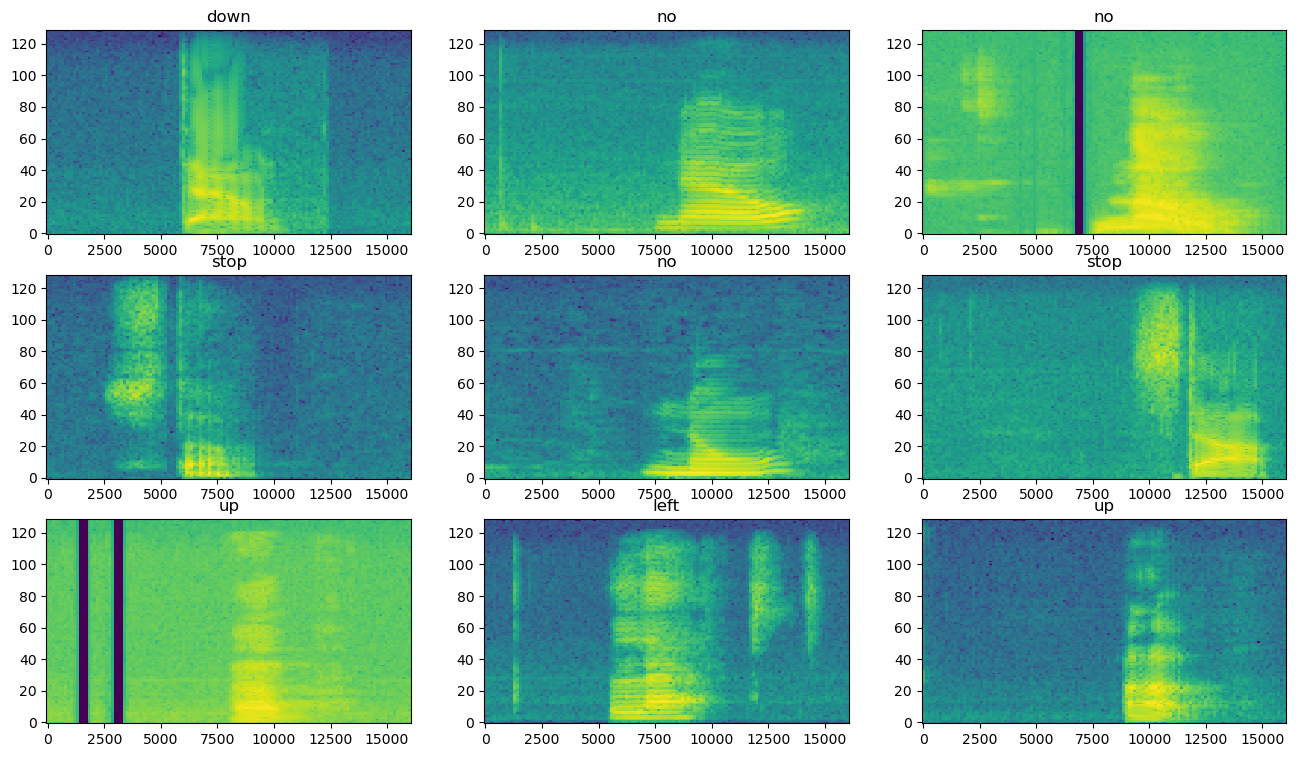

In [45]:
# making spectrograms for different words in the dataset

for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
    break
    
# plotting the graphs

rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize = (16, 9))

for i in range(n):
    r = i//cols
    c = i% cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(commands[example_spect_labels[i].numpy()])
    
plt.show()

## after all this preprocessing we can now build out model and then evaluate the performance

In [46]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

#### the above step will reduce the read latency 

in this we will use a very simple CNN and not much more on the spectrogram dataset

In [51]:
input_shape = example_spectrograms.shape[1:]
print('input shape:', input_shape)
num_labels = len(commands)

# Instantiate the Normalization layer
norm_layer = layers.Normalization()
# fit the state of the layer to the spectrograms with normalization.adapt
# adapt method normalizes according to the mean and standard deviation 
norm_layer.adapt(data = train_spectrogram_ds.map(map_func=lambda spec, label: spec))


model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input
    layers.Resizing(32,32),
    # Normalize
    norm_layer,
    layers.Conv2D(32, 3, activation = 'relu'),
    layers.Conv2D(64, 3, activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization_2 (Normalizat  (None, 32, 32, 1)        3         
 ion)                                                            
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           

In [52]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
metrics=['accuracy'],
)

In [63]:
EPOCHS = 100
history = model.fit(
train_spectrogram_ds,
validation_data = val_spectrogram_ds,
epochs = EPOCHS,
callbacks = tf.keras.callbacks.EarlyStopping(verbose = 1, patience = 2),
)

Epoch 1/100
100/100 [==============================] - 1s 10ms/step - loss: 0.3231 - accuracy: 0.8845 - val_loss: 0.4264 - val_accuracy: 0.8672
Epoch 2/100
100/100 [==============================] - 1s 7ms/step - loss: 0.3059 - accuracy: 0.8920 - val_loss: 0.4301 - val_accuracy: 0.8646
Epoch 3/100
100/100 [==============================] - 1s 7ms/step - loss: 0.2727 - accuracy: 0.9058 - val_loss: 0.4216 - val_accuracy: 0.8711
Epoch 4/100
100/100 [==============================] - 1s 7ms/step - loss: 0.2695 - accuracy: 0.9041 - val_loss: 0.4109 - val_accuracy: 0.8581
Epoch 5/100
100/100 [==============================] - 1s 7ms/step - loss: 0.2447 - accuracy: 0.9156 - val_loss: 0.4039 - val_accuracy: 0.8672
Epoch 6/100
100/100 [==============================] - 1s 7ms/step - loss: 0.2297 - accuracy: 0.9177 - val_loss: 0.3966 - val_accuracy: 0.8802
Epoch 7/100
100/100 [==============================] - 1s 7ms/step - loss: 0.2091 - accuracy: 0.9297 - val_loss: 0.4379 - val_accuracy: 0.867

### Plotting the training and validation loss and accuracy curves improves through the training epochs

C:\Users\chauh\AppData\Local\Temp\ipykernel_41680\2003447018.py:5: UserWarning: Legend does not support 'loss' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend(["loss"], ["val_loss"])


Text(0, 0.5, 'Accuracy [%]')

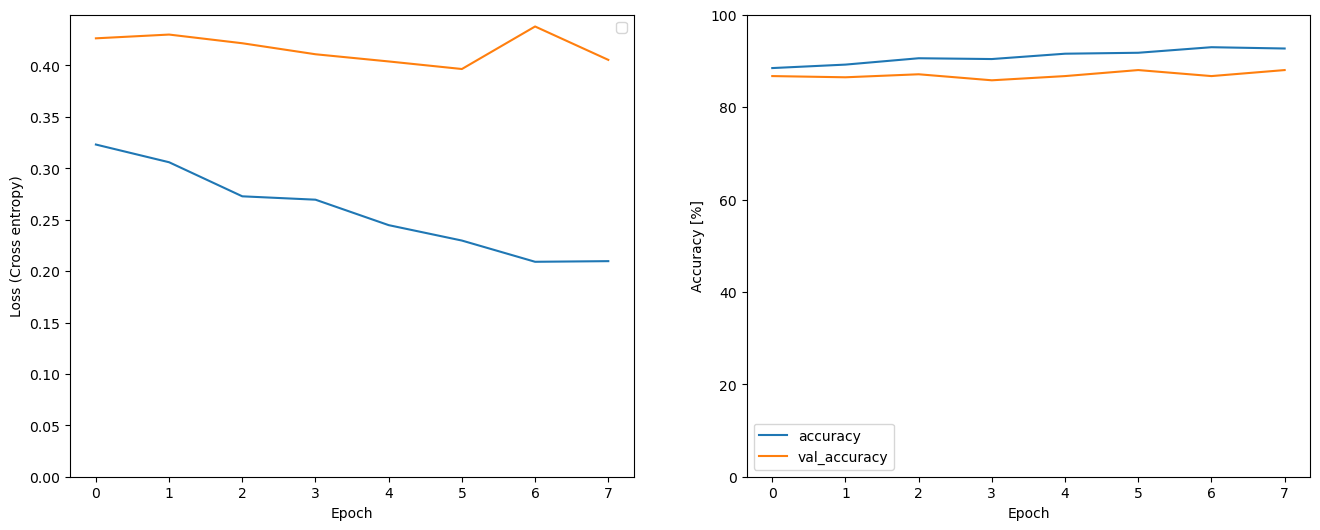

In [70]:
metrics = history.history
plt.figure(figsize = (16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(["loss"], ["val_loss"])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss (Cross entropy)')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [65]:
model.evaluate(test_spectrogram_ds, return_dict=True)

13/13 [==============================] - 0s 4ms/step - loss: 0.4632 - accuracy: 0.8630


{'loss': 0.46323883533477783, 'accuracy': 0.8629807829856873}

In [66]:
y_pred = model.predict(test_spectrogram_ds)

13/13 [==============================] - 0s 3ms/step


In [67]:
y_pred = tf.argmax(y_pred, axis=1)

In [68]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s, lab: lab)), axis=0)

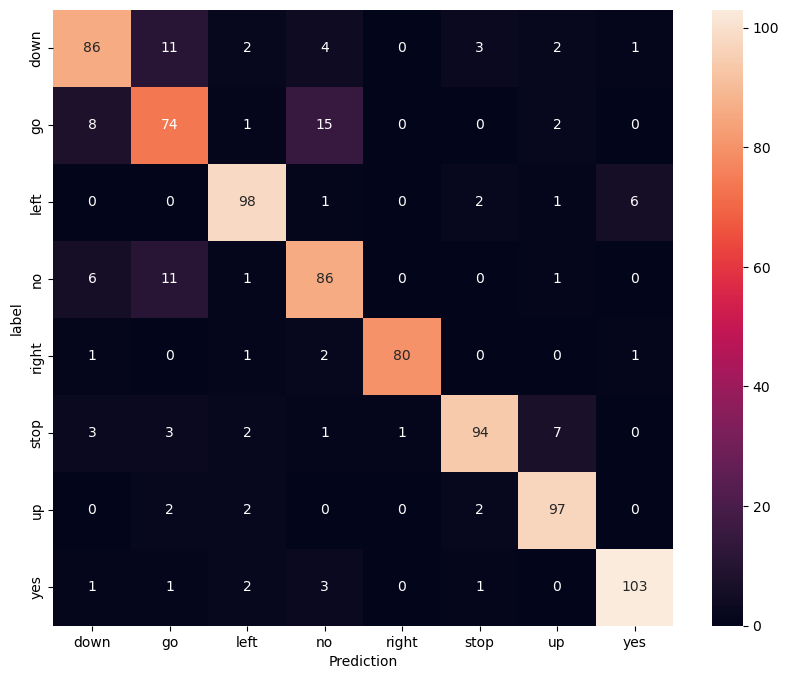

In [69]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx,
           xticklabels=commands,
           yticklabels=commands,
           annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('label')
plt.show()

In [1]:
class ExportModel(tf.Module):
    def __init__(self, model):
        self.model = model
        
        self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
        self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))
        
    @tf.function
    def __call__(self, x):
        
        if x.dtype == tf.string:
            x = tf.io.read_file(x)
            x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
            x = tf.sqeeze(x, axis=-1)
            x = x[tf.newaxis, :]
            
        x = get_spectrogram(x)
        result = self.model(x, training = False)
        
        class_ids = tf.argmax(result, axis = -1)
        class_names = tf.gather(label_names, class_ids)
        return{
            'predictions': result,
            'class_ids': class_ids,
            'class_names': class_names
        }
        

NameError: name 'tf' is not defined